### Project Setup

### Imports and paths

Define the import of the libraries needed in order to run the model

In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split

Define the paths of our drive and mount them from google

In [ ]:
master_path = os.path.join("../gdrive/MyDrive/AN2DL Challenge PolliKungFu/SecondChallenge")
data_path = os.path.join(master_path, "data/")
models_path = os.path.join(master_path, "models/")

In [ ]:
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Import of the data from the NumPy files

In [ ]:
dataset = np.load(os.path.join(data_path, "training_data.npy"), allow_pickle=True)
lst = dataset
print(lst.shape)

categories = np.load(os.path.join(data_path, "categories.npy"), allow_pickle=True)
lst = categories
print(lst)

valid_periods = np.load(os.path.join(data_path, "valid_periods.npy"), allow_pickle=True)
lst = valid_periods
print(lst)

(48000, 2776)
['D' 'D' 'D' ... 'F' 'F' 'F']
[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


### Useful functions

Function in order to plot the signals divided in categories

In [ ]:
def inspect_dataset(dataset, categories, valid_periods, num_of_samples=1,):
    categories_list = np.unique(categories)
    figs, axs = plt.subplots(len(categories_list), 1, sharex=False, figsize=(17,17))
    for i, cat in enumerate(categories_list):
      num_for_plot=num_of_samples
      for k, matchcat in enumerate(categories):
        if matchcat == cat:
            serie=dataset[k][valid_periods[k]:]
            axs[i].plot(range(valid_periods[k], len(dataset[k])), serie)
            axs[i].set_title(categories[k])
            num_for_plot = num_for_plot-1
            if num_for_plot == 0:
                break
    plt.show()

The following functions are not used in the final model since they performed worst or couldn't be used (look at the report) but they are just for demonstration purpose on the failed attempts

In [ ]:
def detrend_signal(signal, plotting=False):
    detrend_signal = signal[1:len(signal)]-signal[:len(signal)-1]
    detrend_signal = np.concatenate((np.array([0]), detrend_signal), axis=0)
    if plotting:
        plt.plot(signal, label='Original signal')
        plt.plot(detrend_signal, label='Detrended signal')
        plt.legend()
        plt.show()
    return detrend_signal

In [ ]:
def reconstruct_signal(signal, original_signal, plotting=False):
    reconstructed_signal = [original_signal[1]]
    for i in range(1, len(signal)):
        reconstructed_signal.append(signal[i]+reconstructed_signal[-1])
    if plotting:
        plt.plot(signal, label='Detrended signal')
        plt.plot(reconstructed_signal, label='Reconstructed signal')
        plt.legend()
        plt.show()
    return np.array(reconstructed_signal)

In [ ]:
def reconstruct_prediction(prediction, original_signal, plotting=False):
    reconstructed_prediction = [original_signal[-1]]
    for i in range(len(prediction)):
        reconstructed_prediction.append(prediction[i]+reconstructed_prediction[-1])
    if plotting:
        plt.plot(prediction, label='Detrended prediction')
        plt.plot(reconstructed_prediction, label='Reconstructed prediction')
        plt.legend()
        plt.show()
    return np.array(reconstructed_prediction[1:])

In [ ]:
def periodgram_generator(signal, plotting=False):
    freq, per = periodogram(signal)
    period = int(1/freq[per.argmax()])
    if plotting:
        plt.plot(freq, per, label='Periodogram')
        plt.xlabel('Frequency')
        plt.ylabel('Power/Frequency')
        plt.legend()
        plt.show()
    return period

In [ ]:
def seasonality_generator(signal, plotting=False):
    to_cut=False
    period = periodgram_generator(signal, plotting)
    min_required_observations = 2 * period
    if len(signal) < min_required_observations:
        original_len = len(signal)
        signal = np.concatenate([signal, signal])
        to_cut=True
    period = min(period, len(signal) // 2)
    decom = dec(signal, model='additive', period=period)
    seas = decom.seasonal
    if to_cut:
        seas = seas[:original_len]

    if plotting:
        plt.plot(signal, label='Original signal')
        plt.plot(seas, label="Seasonality")
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return seas

In [ ]:
def deseason_singal(signal, plotting=False):
    deseasoned_signal = signal - seasonality_generator(signal)
    if plotting:
        plt.plot(signal, label='Original signal')
        plt.plot(deseasoned_signal, label="Deseasoned signal")
        plt.legend()
        plt.show()
    return deseasoned_signal

In [ ]:
def reseason_signal(deseasoned_signal, season, plotting=False):
    reseasoned_signal = deseasoned_signal + season
    if plotting:
        plt.plot(deseasoned_signal, label='Deseasoned signal')
        plt.plot(reseasoned_signal, label="Reseasoned signal")
        plt.legend()
        plt.show()
    return reseasoned_signal

In [ ]:
def remove_outliers(data, valid_periods, categories, threshold=3):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    z_scores = np.abs((data - mean) / std)
    mask = (z_scores < threshold).all(axis=1)
    return data[mask], valid_periods[mask], categories[mask]

### Data Analysis

Print of useful information sucha as shapes, valid periods and data plotting

In [ ]:
print(categories.shape)
print(valid_periods.shape)
print(dataset.shape)

(48000,)
(48000, 2)
(48000, 2776)


In [ ]:
print("Min value start period: ", np.min(valid_periods[:,0]))
print("Max value start period: ", np.max(valid_periods[:,0]))
print("Min value end period: ", np.min(valid_periods[:,1]))
print("Max value end period: ", np.max(valid_periods[:,1]))

Min value start period:  0
Max value start period:  2752
Min value end period:  2776
Max value end period:  2776


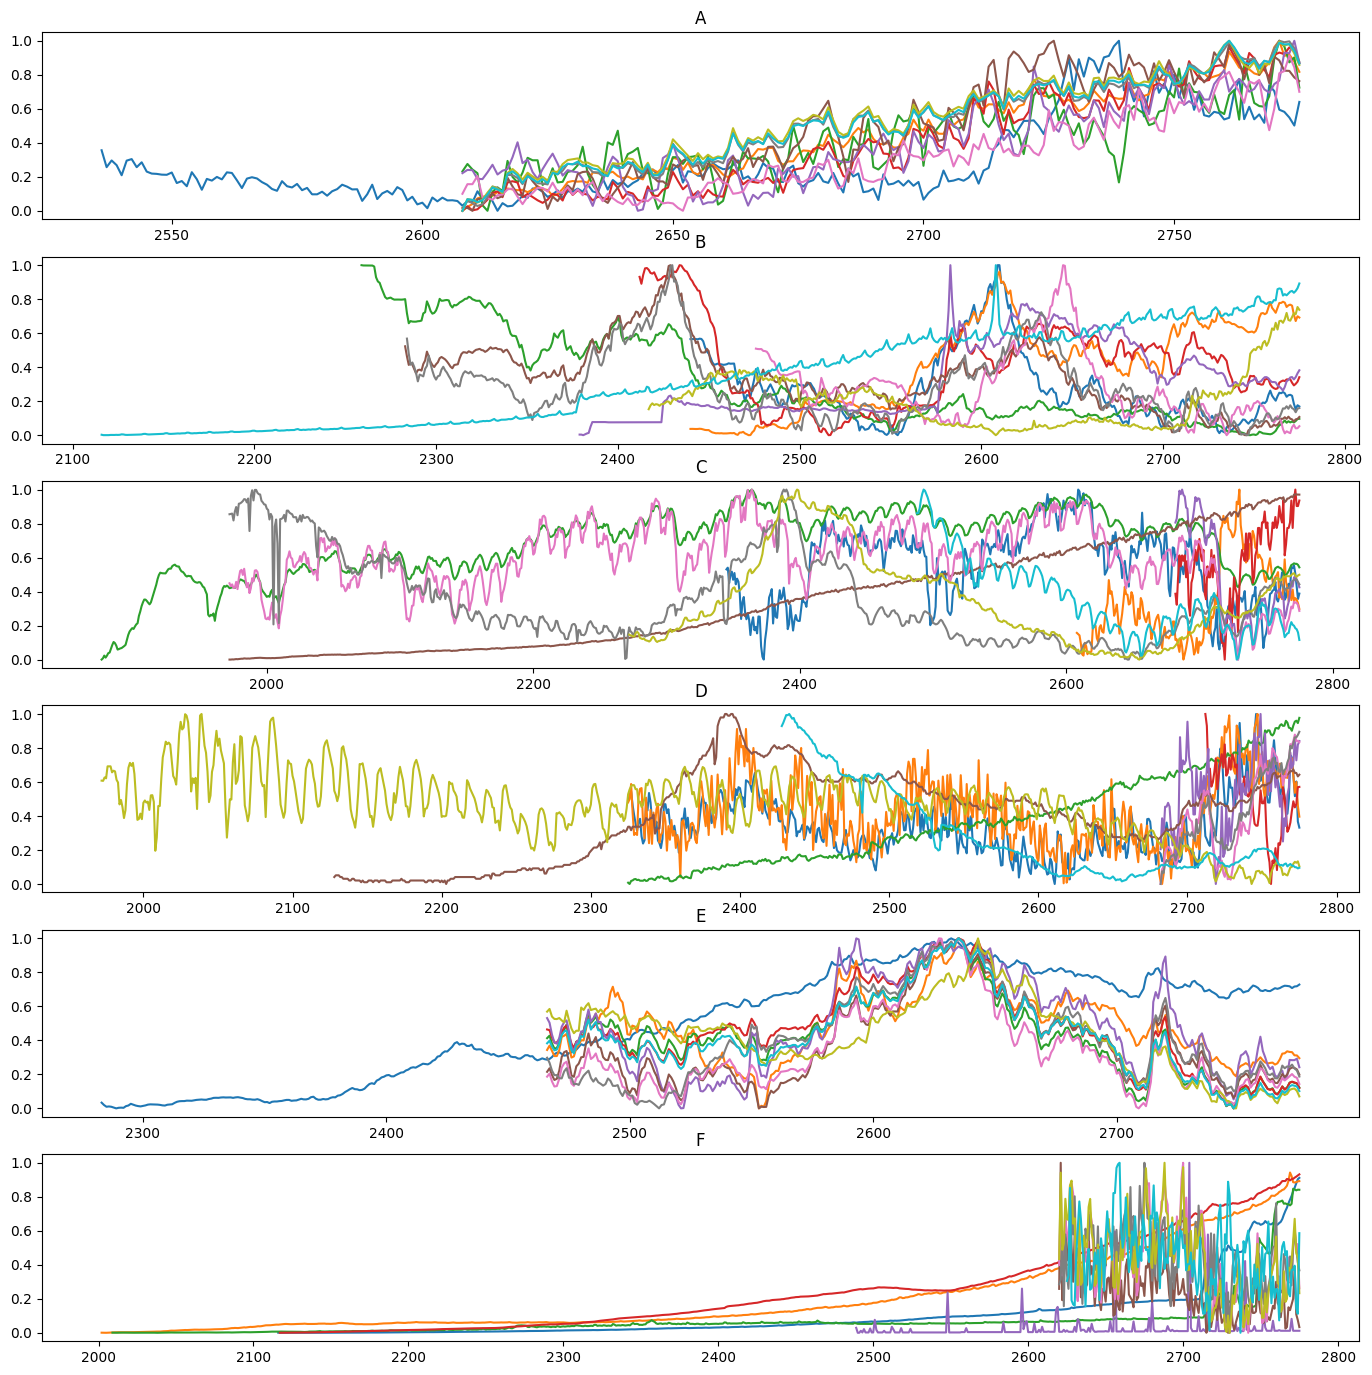

In [ ]:
inspect_dataset(dataset, categories, valid_periods[:,0], 10)

Demonstration of Detrend of the signals and reconstructions of them and their predictions (dummy)

Detrend of signal: 


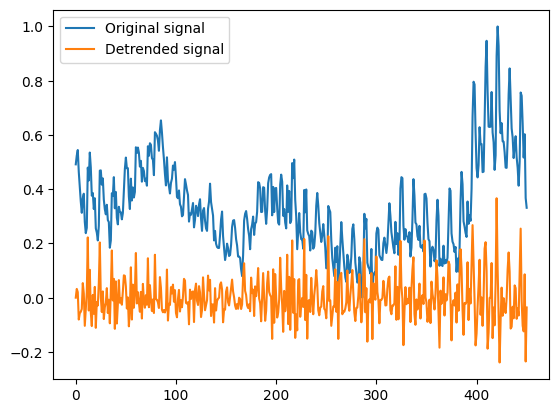

Reconstruction of signal: 


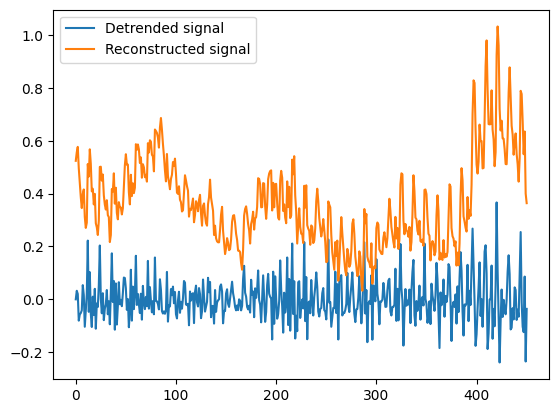

Reconstruct of prediction from original signal: 


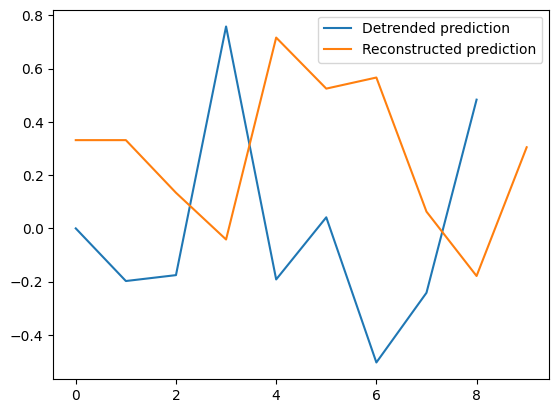

Reconstruct of prediction from reconstructed signal: 


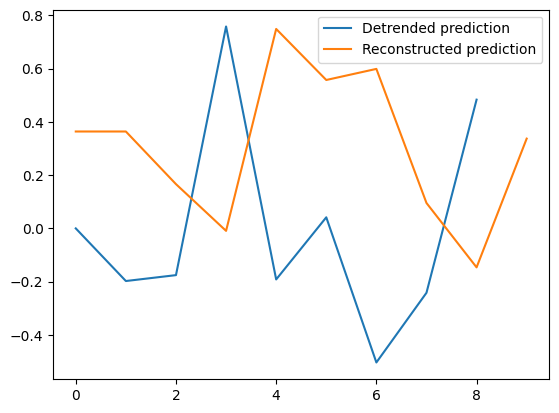

In [ ]:
signal = dataset[0, valid_periods[0][0]:]
print("Detrend of signal: ")
int_sig = detrend_signal(signal, True)
print("Reconstruction of signal: ")
rec_sig = reconstruct_signal(int_sig, signal, True)
dummy_pred = detrend_signal(np.random.rand(9))
print("Reconstruct of prediction from original signal: ")
rec_pred = reconstruct_prediction(dummy_pred, signal, True)
print("Reconstruct of prediction from reconstructed signal: ")
rec_pred = reconstruct_prediction(dummy_pred, rec_sig, True)

### Splitting Train and Validation

Taking just the valid portion of the signals and splitting into train and test

In [ ]:
data = []
index = 0
for i in range(dataset.shape[0]):
    signal = dataset[i]
    valid = valid_periods[i]
    valid_signal = signal[valid_periods[i][0]:valid_periods[i][1]]
    data.append(valid_signal)
    index = index + 1

len(data), data[0].shape, data[500].shape

(48000, (451,), (157,))

In [ ]:
test_size = 0.05
train_set, test_set = train_test_split(data, test_size=test_size, stratify=categories)
len(train_set), len(test_set)

(45600, 2400)

Defining informations for the build of the sequences

In [ ]:
window = 200
stride = 5
telescope = 9

In [ ]:
def build_sequences(data, window=200, stride=20, telescope=9):
    assert window % stride == 0
    dataset = []
    labels = []
    temp_data = data.copy()
    padding_check = len(data)%window

    for i in range(len(data)):
        if(padding_check != 0):
            padding_len = window - len(temp_data[i])%window
            padding = np.zeros((padding_len), dtype='float32')
            temp_data[i] = [padding, temp_data[i]]
            assert len(temp_data) % window == 0

        for j in np.arange(0,len(temp_data[i])-window-telescope,stride):
            dataset.append(temp_data[i][j:j+window])
            labels.append(temp_data[i][j+window:j+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

Generation of the sequence of train and test, defining the input and output shapes of the model

In [ ]:
X_train, y_train = build_sequences(train_set, window, stride, telescope)
X_test, y_test = build_sequences(test_set, window, stride, telescope)
input_shape = (X_train.shape[1],)
output_shape = (y_train.shape[1],)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((447138, 200), (447138, 9), (24324, 200), (24324, 9))

Visualization of the splitting of train and test with the window (X) and the stride (y)

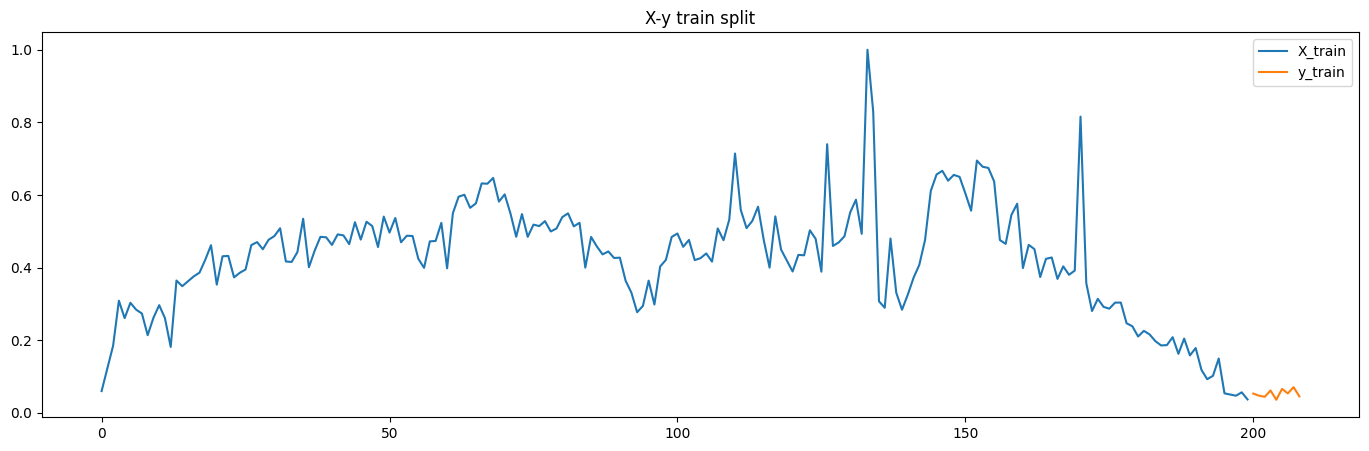

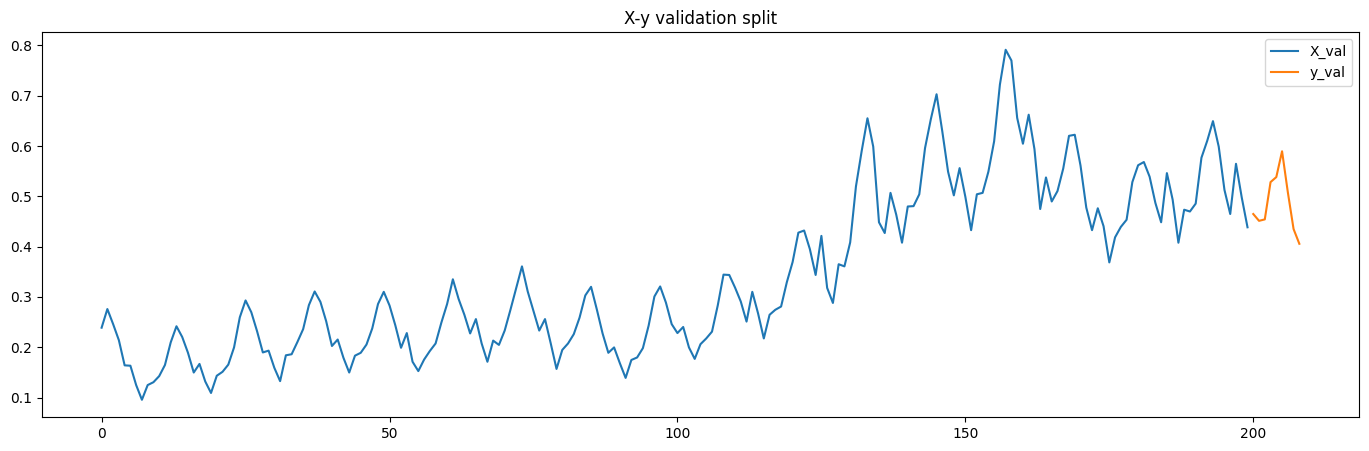

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(range(0, window), X_train[0], label='X_train')
plt.plot(range(window, window+telescope), y_train[0], label='y_train')
plt.title('X-y train split')
plt.legend()
plt.show()
plt.figure(figsize=(17,5))
plt.plot(range(0, window), X_test[0], label='X_val')
plt.plot(range(window, window+telescope), y_test[0], label='y_val')
plt.title('X-y validation split')
plt.legend()
plt.show()

### Model

Function for the definition of the sequential model

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    model = tfk.Sequential()
    model.add(tfkl.Reshape((input_shape[0], 1)))

    model.add(tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm'))
    model.add(tfkl.LSTM(64, return_sequences=True, name='lstm'))

    model.add(tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv'))
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.GlobalAveragePooling1D())
    model.add(tfkl.Dense(output_shape[0], name='output'))

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    model.build((None, input_shape[0]))
    return model

Model instance and summary of it

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 200, 1)            0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          133120    
 ctional)                                                        
                                                                 
 lstm (LSTM)                 (None, 200, 64)           82176     
                                                                 
 conv (Conv1D)               (None, 200, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                

Training the model and saving it into the drive

In [ ]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    shuffle=True,
    epochs = 50,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
)
model.save(os.path.join(models_path, 'model'))

Epoch 1/50
1747/1747 [==============================] - 106s 55ms/step - loss: 0.0142 - val_loss: 0.0088 - lr: 0.0010
Epoch 2/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0084 - val_loss: 0.0077 - lr: 0.0010
Epoch 3/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0078 - val_loss: 0.0073 - lr: 0.0010
Epoch 4/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0075 - val_loss: 0.0072 - lr: 0.0010
Epoch 5/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0073 - val_loss: 0.0072 - lr: 0.0010
Epoch 6/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0071 - val_loss: 0.0067 - lr: 0.0010
Epoch 7/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0067 - val_loss: 0.0063 - lr: 0.0010
Epoch 8/50
1747/1747 [==============================] - 94s 54ms/step - loss: 0.0063 - val_loss: 0.0061 - lr: 0.0010
Epoch 9/50
1747/1747 [==============================] - 94s 54m

### View Results

Load of the model and visualize the difference between an original signal and a predicted one

In [ ]:
model = tf.keras.models.load_model(os.path.join(models_path, 'model'))

In [ ]:
X, y = build_sequences(train_set, window, stride, telescope)
pred = model.predict(np.reshape(X[0], (1, 200)))

1/1 [==============================] - 1s 1s/step


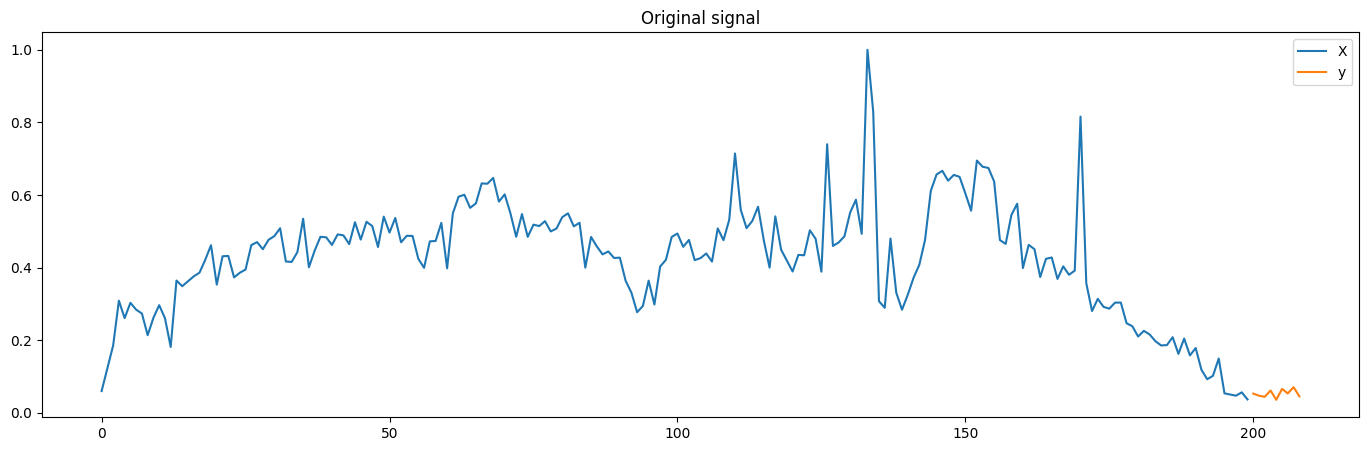

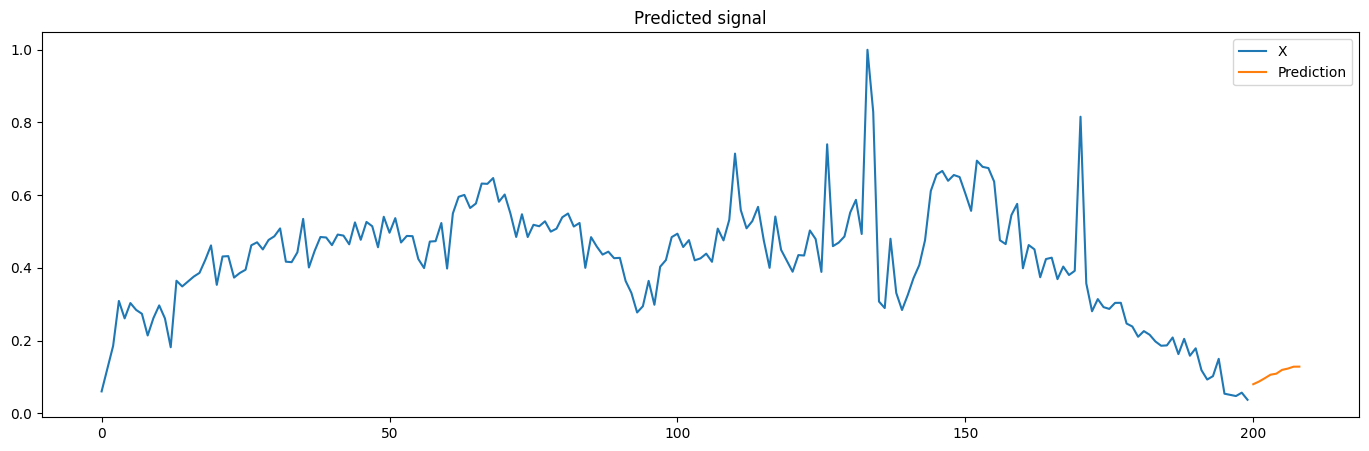

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(range(0, window), X[0], label='X')
plt.plot(range(window, window+telescope), y[0], label='y')
plt.title('Original signal')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(range(0, window), X[0], label='X')
plt.plot(range(window, window+telescope), pred[0], label='Prediction')
plt.title('Predicted signal')
plt.legend()
plt.show()

### Autoregressive

Function for autorgressive predictions and visualization of the final predicted signal

In [ ]:
def forecast_sequence(model, signal, telescope=9):
    current_signal = signal.copy()

    for _ in range(telescope):
        # Reshape current sequence for prediction (1, time steps, features)
        current_signal_reshaped = current_signal.reshape((1, len(signal)))

        # Predict the next value
        next_value = model.predict(current_signal_reshaped, verbose=0)

        # Append the predicted value to the sequence
        current_signal = np.append(current_signal, next_value)
        current_signal = current_signal[next_value.shape[1]:]

    return current_signal

In [ ]:
window=200
telescope=9
model = tf.keras.models.load_model(os.path.join(models_path, 'model'))
X, y = build_sequences(train_set, window, stride, telescope)
pred = model.predict(np.reshape(X[0], (1, 200)))

1/1 [==============================] - 1s 874ms/step


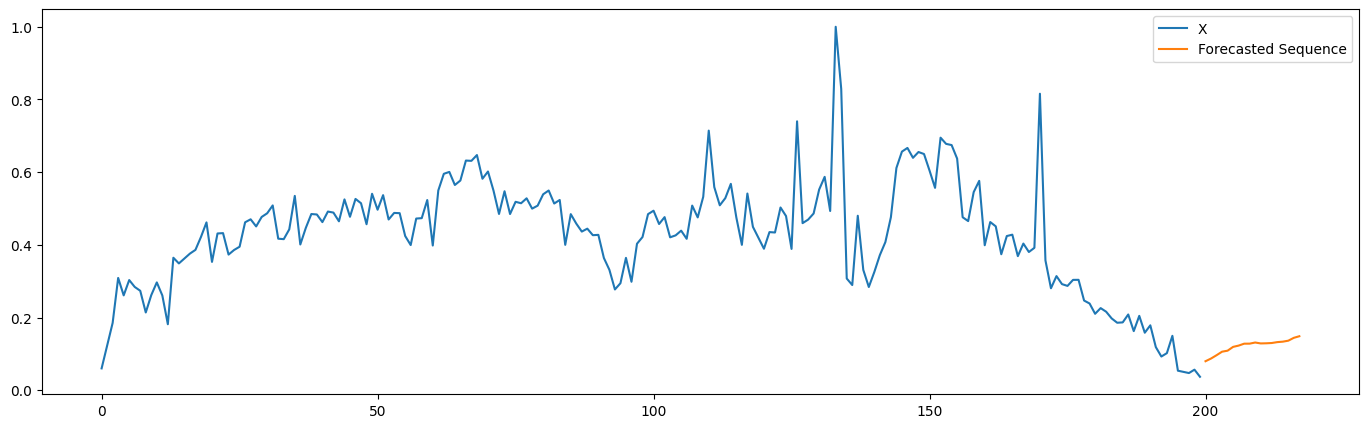

In [ ]:
telescope=int(18/9)
forecasted_sequence = forecast_sequence(model, X[0], telescope)

plt.figure(figsize=(17,5))
plt.plot(range(0, window), X[0], label='X')
plt.plot(range(window, window+18), forecasted_sequence[-18:], label='Forecasted Sequence')
plt.legend()
plt.show()